# Exercise and Non-Exercise Predictors of Heart Disease

Heart disease (HD) has many symptoms, thus, its diagnosis is difficult. It is critical to minimize testing (Bösner et al., 2010), while “[identifying] serious cardiac disease reliably” (Bösner et al., 2010). Our question is: Can exercise-related parameters more accurately diagnose HD than non-exercise-related predictors? We will create one model employing non-exercise factors including age, resting electrocardiogram, and resting blood pressure, and another for exercise-related factors including ST depression during exercise, angina during exercise, and slope (Detrano, n.d.). We used the “Heart Disease Data Set” (Detrano, n.d.), specifically the processed.cleveland.data, including 14 variables, with the diagnosis denoted from 0-4 (Detrano, n.d.).

In [87]:
#Source for the code:

#Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
#Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [88]:
# Installation of the required libraries to conduct our data analysis. Setting of the seed to ensure our analysis is reproducible.
library(tidyverse)
library(repr)
library(RColorBrewer)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6)
set.seed(9999)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [89]:
# Reading in the data from our online source (Detrano, n.d.) using a read_csv function. 
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<b>WRANGLING THE DATA:</b>

With the data loaded, it is wrangled to create the desired datasets. We assign column names to make the data understandable and select the variables desired for each dataset.

In [90]:
# Set the dataset's column names to the variable descriptions found in (Detrano, n.d.).
colnames(cleveland_data) <- c("age", "sex", "cp", "resting_blood_pressure", "chol", "fbs", "resting_electrocardio", "thalach", "exercise_angina", "exercise_st", "exercise_slope", "ca", "thal", "result")

In [91]:
# Mutate the result column into a factor, so it can be used to color and fill the graphs.
cleveland_data <- cleveland_data |>
                  mutate(result = 
                         case_when(result != 0 ~ 1, result == 0 ~ 0)) |>
                  mutate(result = as_factor(result)) |>
                  filter(!is.na(result)) 
cleveland_data

# Wrangling the data by creating the desired datasets.
# First Dataset: data collected from patients in the non-exercise state.
cleveland_data_resting <- select(cleveland_data, age, resting_blood_pressure, resting_electrocardio, result) 

# Second Dataset: data collected from patients after exercise.
cleveland_data_exercise <- select(cleveland_data, exercise_angina, exercise_st, exercise_slope, result)

age,sex,cp,resting_blood_pressure,chol,fbs,resting_electrocardio,thalach,exercise_angina,exercise_st,exercise_slope,ca,thal,result
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [92]:
# We used map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.
cleveland_data_resting_mean <- cleveland_data_resting |>
    select(age:resting_electrocardio) |>
    map_df(mean)
cleveland_data_resting_mean

age,resting_blood_pressure,resting_electrocardio
<dbl>,<dbl>,<dbl>
54.43894,131.6898,0.990099


<b>Table 1:</b> Non-exercise predictors' means.

In [93]:
# We used map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.

cleveland_data_exercise_mean <- cleveland_data_exercise |>
    select(exercise_angina:exercise_slope) |>
    map_df(mean)
cleveland_data_exercise_mean

exercise_angina,exercise_st,exercise_slope
<dbl>,<dbl>,<dbl>
0.3267327,1.039604,1.60066


<b>Table 2:</b> Exercise predictors' means.  

Our first dataset utilizes non-exercise parameters including age, as this contributes to HD diagnosis, with older ages being risk factors (Bösner et al., 2010). Blood sugar after fasting is included as its correlation to HD has been clinically identified (Shin et al., 2019). Finally, we used resting blood pressure as it constitutes “one of [HD's] most important risk factors” (Wu et al., 2015). 

Our second dataset includes exercise-related predictors. ST depression during exercise is used as it relates to HD outcome, thus having medical value (Lanza et al., 2004). Angina during exercise is used as exercise stresses the heart, exposing this symptom (Harvard Health Publishing, 2021). Finally, the slope is used to study exercise testing's involvement in HD predictions, correlating to the extent of illness (Finkelhor et al., 1986). Both contain the result variable, indicating the categorical diagnosis (Detrano, n.d.).

As an initial summary, we looked at each variable’s means (Tables 1 and 2) to understand their values. The means differ for each variable in a single dataset, thus we are required to scale the data for modeling.

<b>SPLITTING THE DATA INTO TRAINING AND TESTING:</b>

We will perform a $K$-nearest neighbors classification using tidymodels. Thus, we split 75% of the data into training datasets, and the remaining 25% into testing datasets to utilize sufficient data for accurate models. 

In [94]:
# Splitting the datasets into training and testing data using 75% of the data in the training set.
set.seed(9999)

initial_split <- initial_split(cleveland_data_resting, prop = 0.75, strata = result)  
resting_train <- training(initial_split)   
resting_test <- testing(initial_split)

initial_split <- initial_split(cleveland_data_exercise, prop = 0.75, strata = result)  
exercise_train <- training(initial_split)   
exercise_test <- testing(initial_split)

<b>VISUALIZING THE DATA:</b>

Our preliminary visualizations are histograms with the predictors’ values on the x-axis and diagnoses, from 0 (no HD) to 4 (severe HD) on the y-axis.

<b>GROUP 1 GRAPHS:</b>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



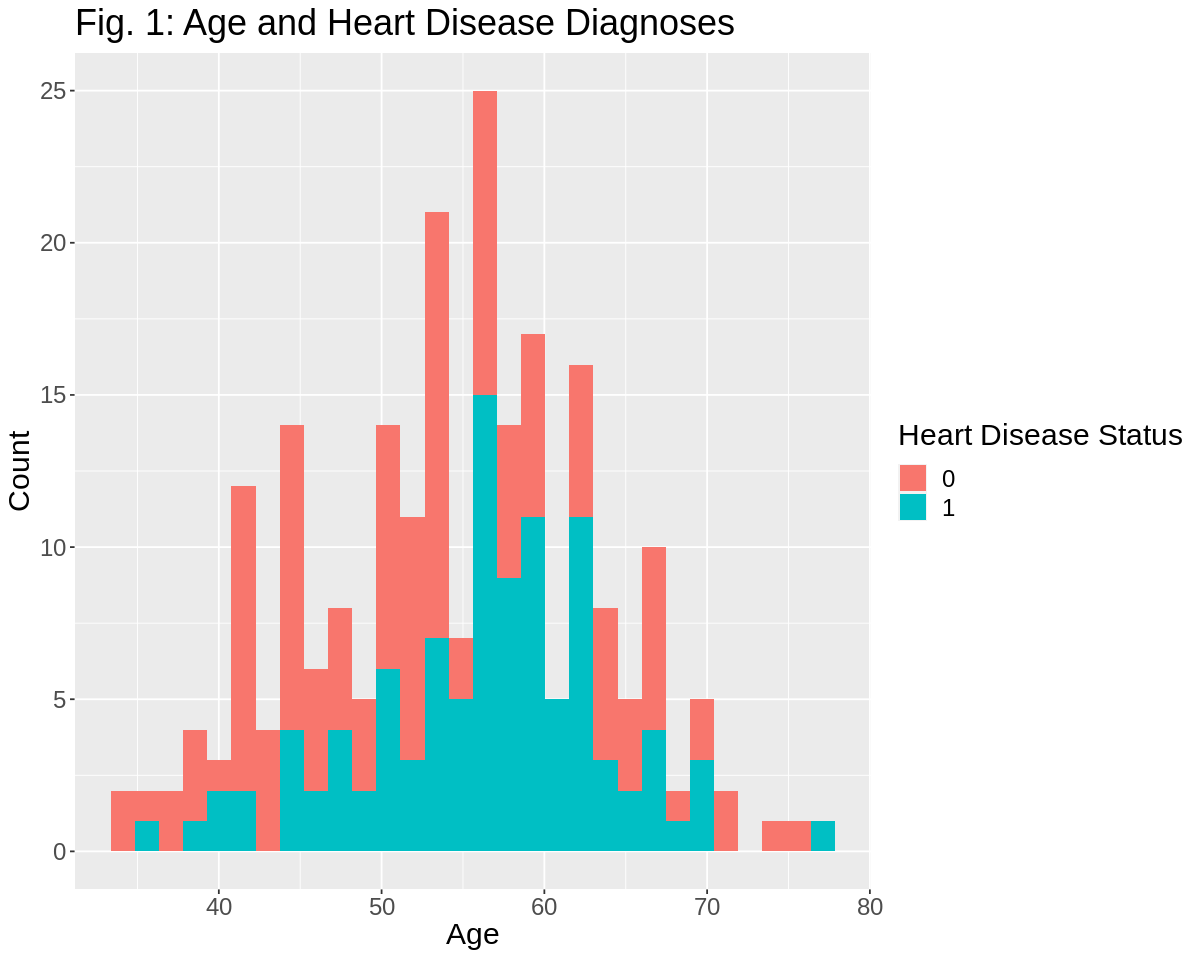

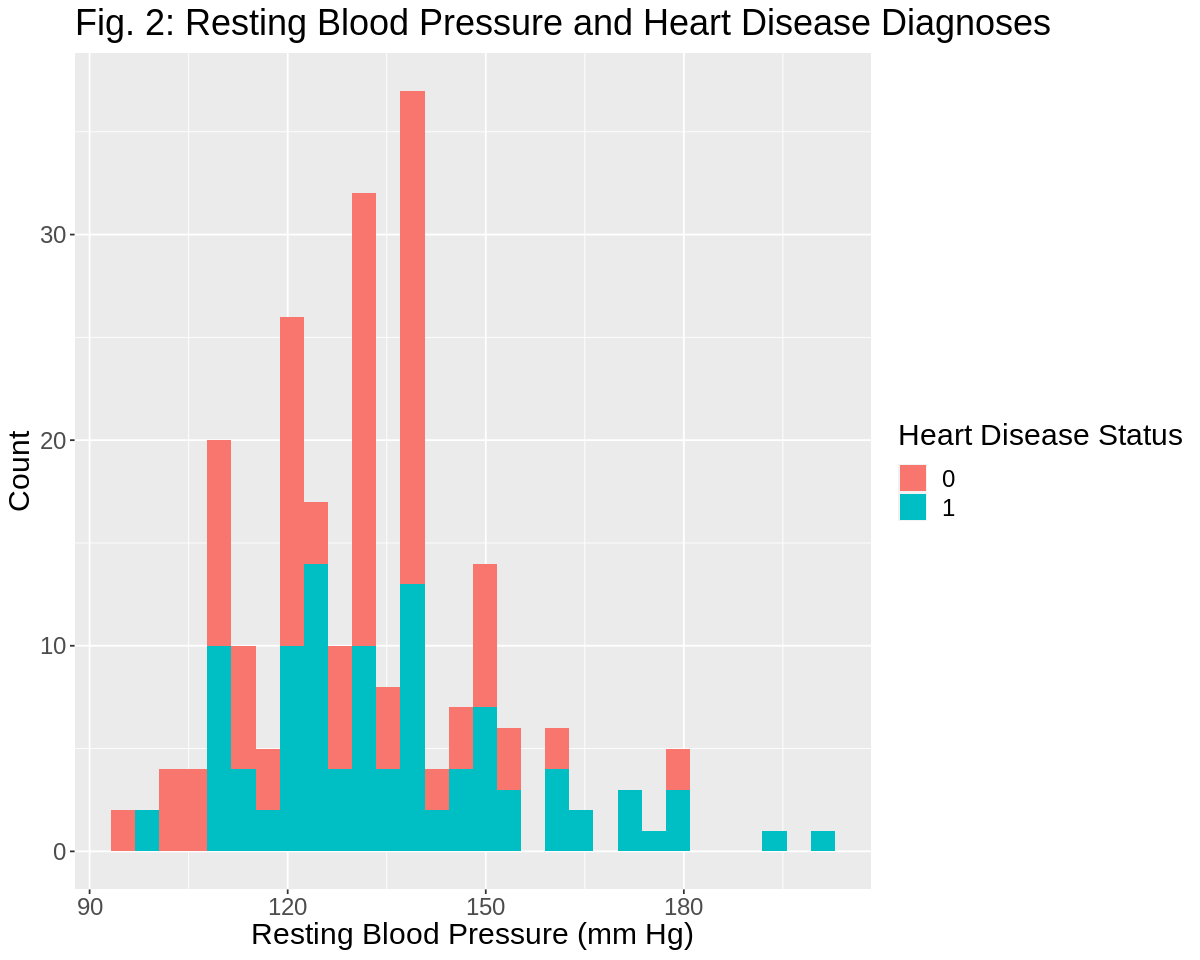

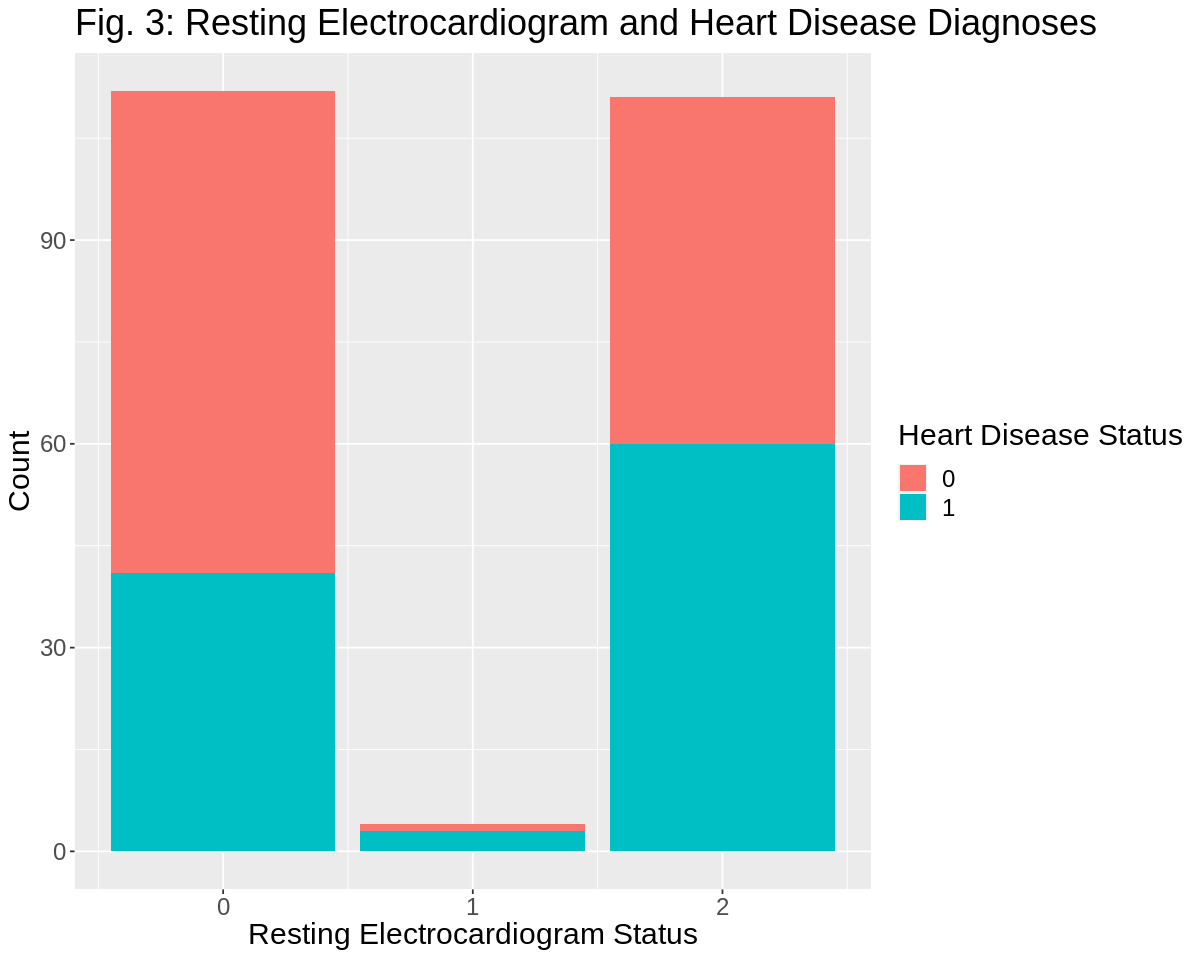

In [95]:
#Creating the plots to visualize the predictors from the first dataset in relation to the severity of heart disease. 
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

resting_age_plot <- ggplot(resting_train, aes(x = age)) +
    ggtitle("Fig. 1: Age and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Age") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
resting_age_plot

resting_bps_plot <- ggplot(resting_train, aes(x = resting_blood_pressure)) +
    ggtitle("Fig. 2: Resting Blood Pressure and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Resting Blood Pressure (mm Hg)") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
resting_bps_plot

resting_electro_plot <- ggplot(resting_train, aes(x = resting_electrocardio)) +
    ggtitle("Fig. 3: Resting Electrocardiogram and Heart Disease Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Resting Electrocardiogram Status") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
resting_electro_plot

These depict the predictors’ distribution, indicating how HD diagnosis is associated with each value. In Fig. 1, ages are between 5 and 75, with most data at ages 50-65. There are more HD diagnoses, relative to non-diagnoses at increased age. In Fig. 2, resting blood pressure has a range of ~95-205 mmHg, with most data at 105-150 mmHg. A majority of these data are not associated with a HD diagnosis. Finally, in Fig. 3, most observations are assigned as either 0 or 2. At resting electrocardiogram of 0, more than half the observations have no HD diagnosis. However, at 2, each diagnosis occurs. This graphical representation emphasizes the importance of scaling the data for modeling. 

<b>GROUP 2 GRAPHS:</b>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



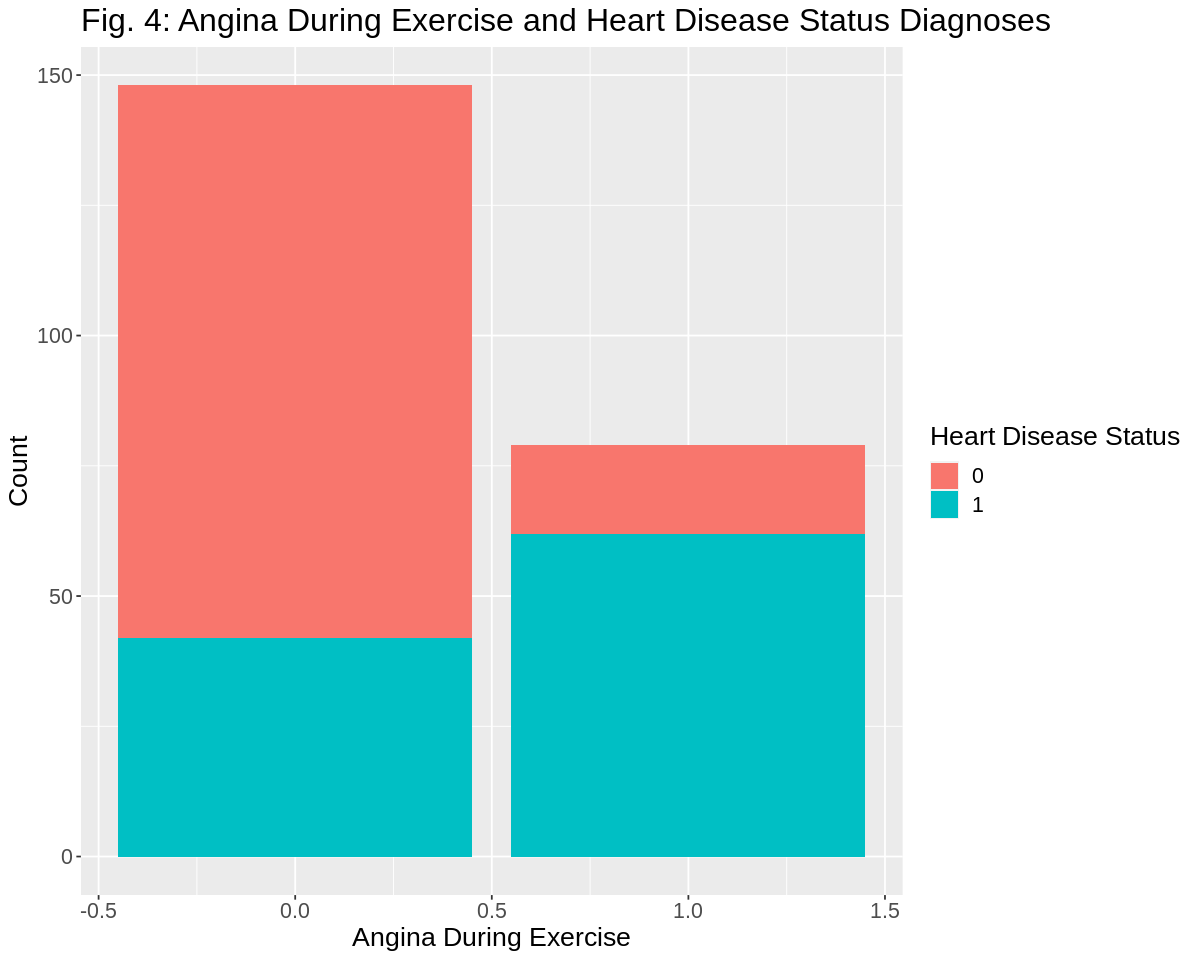

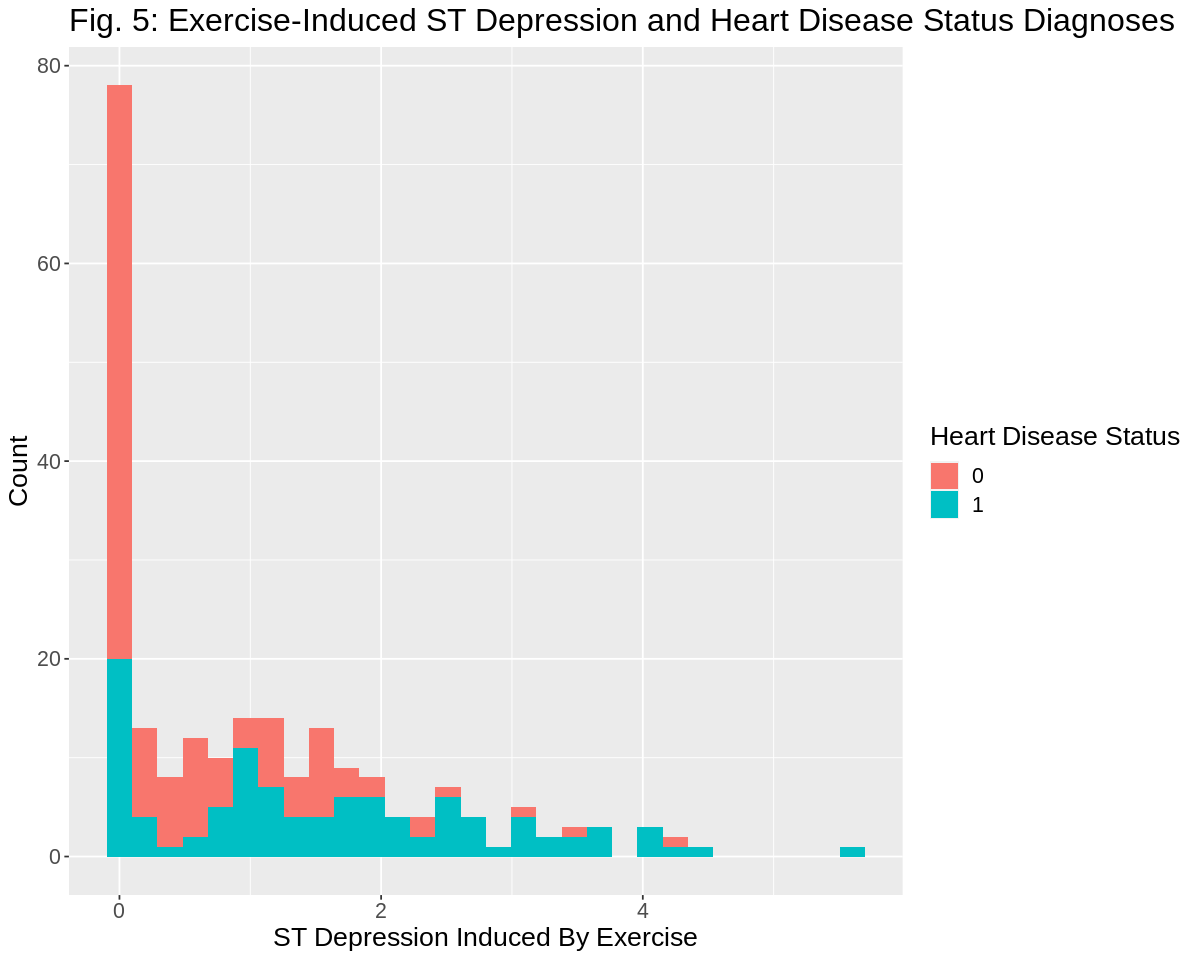

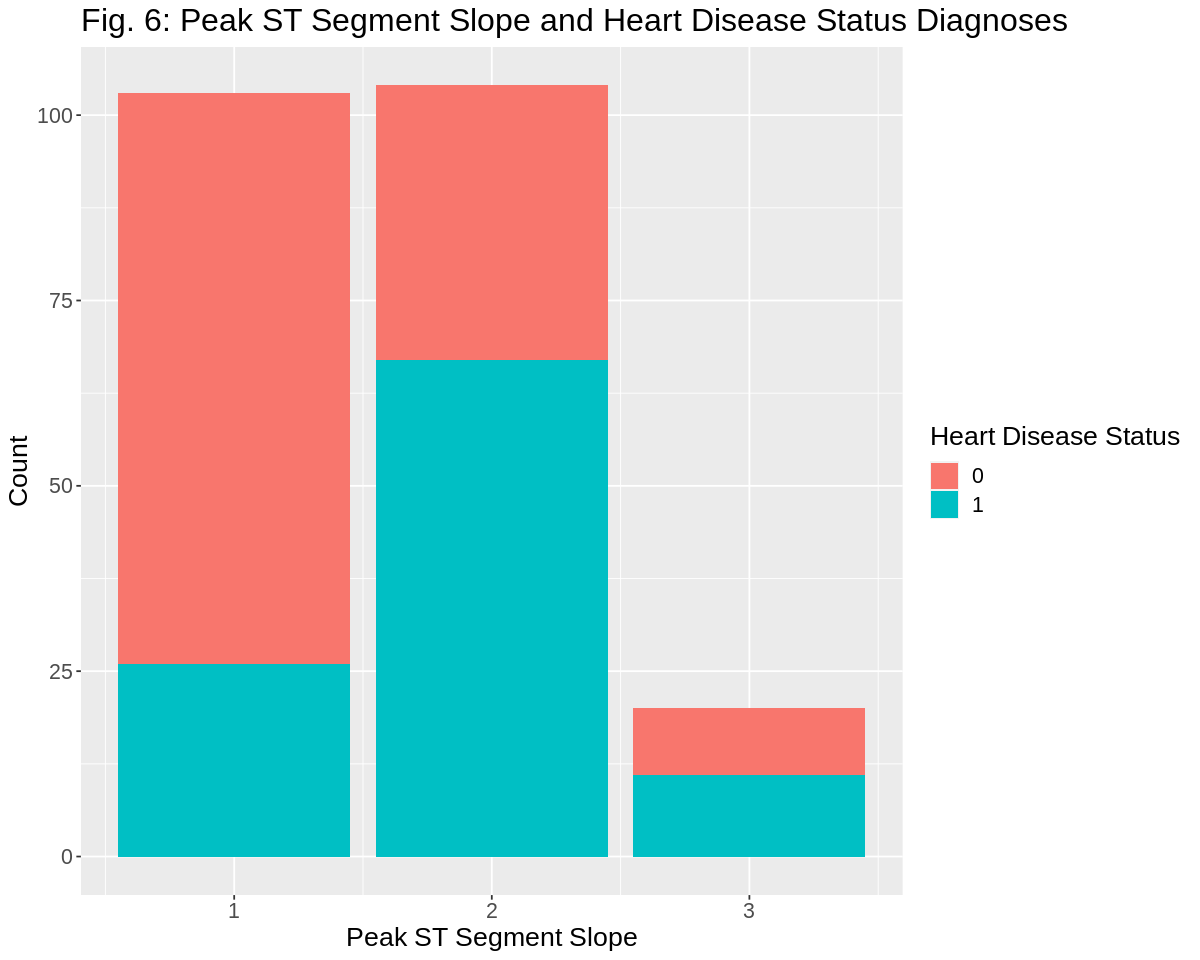

In [96]:
#Creating the plots to visualize the predictors in the second data set in relation to the severity of heart disease.
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

exercise_angina <- ggplot(exercise_train, aes(x = exercise_angina)) +
    ggtitle("Fig. 4: Angina During Exercise and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Angina During Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
exercise_angina

exercise_st_plot <- ggplot(exercise_train, aes(x = exercise_st)) +

    ggtitle("Fig. 5: Exercise-Induced ST Depression and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("ST Depression Induced By Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
exercise_st_plot

exercise_slope_plot <- ggplot(exercise_train, aes(x = exercise_slope)) +
    ggtitle("Fig. 6: Peak ST Segment Slope and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Peak ST Segment Slope") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
exercise_slope_plot

These histograms demonstrate the association between our exercise predictors and HD diagnosis. In Fig. 4, exercise angina is a binary predictor, associated with values 0 or 1. More observations have a value of 0 than of 1. A majority of those with 0 angina have no HD diagnosis. With angina of 1, each HD diagnosis is represented. Fig. 5 depicts the ST depression during exercise, holding values between 0 and 4.5. The largest proportion is at 0, and the majority have no HD diagnosis. With increasing ST depression, more diagnoses occur. Finally, in Fig. 6, the peak ST segment slope adopts values of 1, 2, or 3. Most observations are at values of 1 or 2, and the number of individuals with no HD diagnosis decreases as the predictor's value increases. These graphs expose our data’s range, allowing us to make preliminary predictions regarding their associated HD diagnosis.

<b>NON-EXERCISE PREDICTORS MODELLING:</b>

Our first model predicts HD diagnosis using non-exercise predictors. Its accuracy with the testing data will allow us to determine whether a diagnostic paradigm for HD including these variables will be appropriate. 

We need to determine the number of each diagnosis in our training data to determine if the classes are balanced.

In [97]:
# Determining the number of observations of each result to determine if we need to balance the classes.

number_of_each_result_resting <- resting_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result_resting

result,count
<fct>,<int>
0,123
1,104


<b>Table 3:</b> This shows a varying number of observations associated with each result in the training dataset, thus the classes are not balanced. Thus we will have to create a balanced dataset for modeling.

In [98]:
set.seed(9999)

# Creating a recipe to upsample the data so that we can balance the classes. 
balanced_recipe_resting <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = resting_train) |>
                                step_upsample(result, over_ratio = 1, skip = FALSE) |>
                                prep()

# Baking this recipe with our training data so that the classes are balanced. 
balanced_resting_train <- bake(balanced_recipe_resting, resting_train)

This recipe indicates we are classifying with respect to the result variable, using our three non-exercise predictors. This scales and centers the data, so a single predictor cannot have a larger effect on the model, due to its wider range. 

In [99]:
# Creating a recipe for the classification using the resting data. 
set.seed(9999)

resting_recipe <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = balanced_resting_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

We specify a classification model, indicating that we are tuning the number of neighbours, allowing us to find a $K$ with optimal accuracy. 


In [100]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

resting_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

To tune the model, we perform cross-validation on the training dataset, training the model on a portion, and testing it on the validation set, estimating the $K$ values’ accuracy, specified in the tibble. These are included in the workflow to collect the metrics.

In [101]:
set.seed(9999)

# Creating a cross validation set. 

resting_vfold <- vfold_cv(resting_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 1))
                   
# Creating a workflow to determine the best K. 

resting_model_workflow <- workflow() |>
                            add_recipe(resting_recipe) |>
                            add_model(resting_model_tune) |>
                            tune_grid(resamples = resting_vfold, grid = k_to_try) |>
                            collect_metrics()

We plot the $K$ values' accuracy from the workflow, to identify the best $K$ to use for modeling.

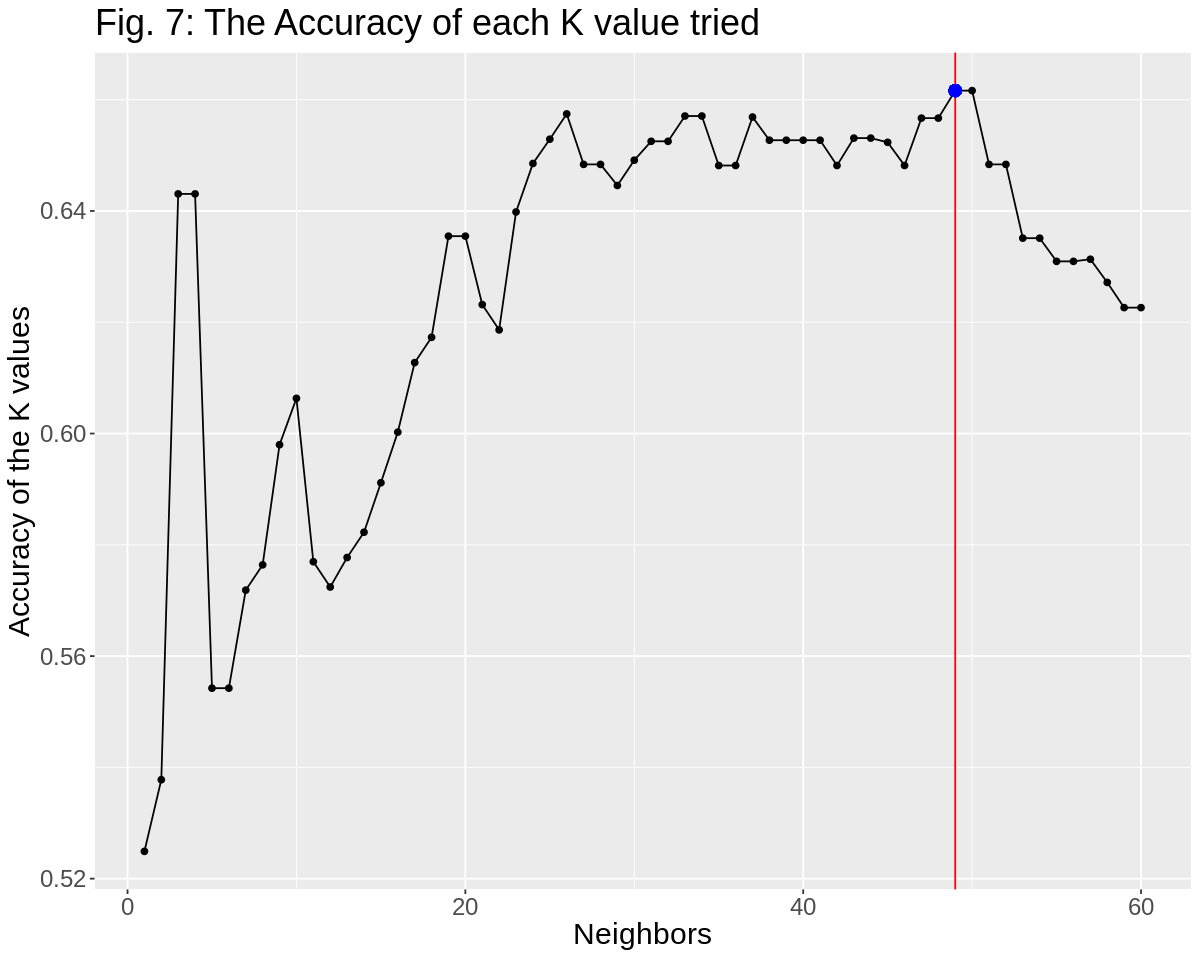

In [117]:
# Filtering the accuracy of each K from the metrics.

accuracy_of_k <- resting_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

highest_accuracy_k <- accuracy_of_k|>
                filter(neighbors == 49) |> 
                select(mean) |>
                pull()

accuracy_plot <- accuracy_of_k |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 49, colour = "red") +
                    geom_point(aes(x = 49, y = highest_accuracy_k), size = 3, colour = "blue") +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("Fig. 7: The Accuracy of each K value tried") +
                    theme(text = element_text(size = 18))

accuracy_plot

From the above plot, we choose $K$=49 to build this model as it generates the highest accuracy, and its adjacent values are accurate too. 

With the best $K$, we create a new model and fit it to the above resting_train, our training data. This trains the model, without seeing the testing data, thus we obtain a good accuracy estimate by predicting the testing data’s labels. 

In [118]:
set.seed(9999)

# Creating a new model which includes the new K to generate the best fit. 

best_resting_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 49) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_resting_fit <- workflow() |>
                        add_recipe(resting_recipe) |>
                        add_model(best_resting_model) |>
                        fit(data = balanced_resting_train)

# Fitting the model to our testing data to make the predictions. 

resting_predictions <- best_resting_fit |>
                        predict(resting_test) |>
                        bind_cols(resting_test)

In [119]:
set.seed(9999)

# Looking at the metrics and confusion matrix for this model to determine its accuracy.

resting_metrics <- resting_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
resting_metrics

resting_conf_mat <- resting_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
resting_conf_mat

[1] 0.5657895

          Truth
Prediction  0  1
         0 25 17
         1 16 18

<b>Table 4:</b> Our resting model provides an accuracy of ~0.25, thus accurately diagnoses 25% of the time. From the confusion matrix, we know it recognizes and predicts all results.

Our majority classifier is the 0 result, and represents 54% of the data. Thus, our model performs worse than the majority classifier.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



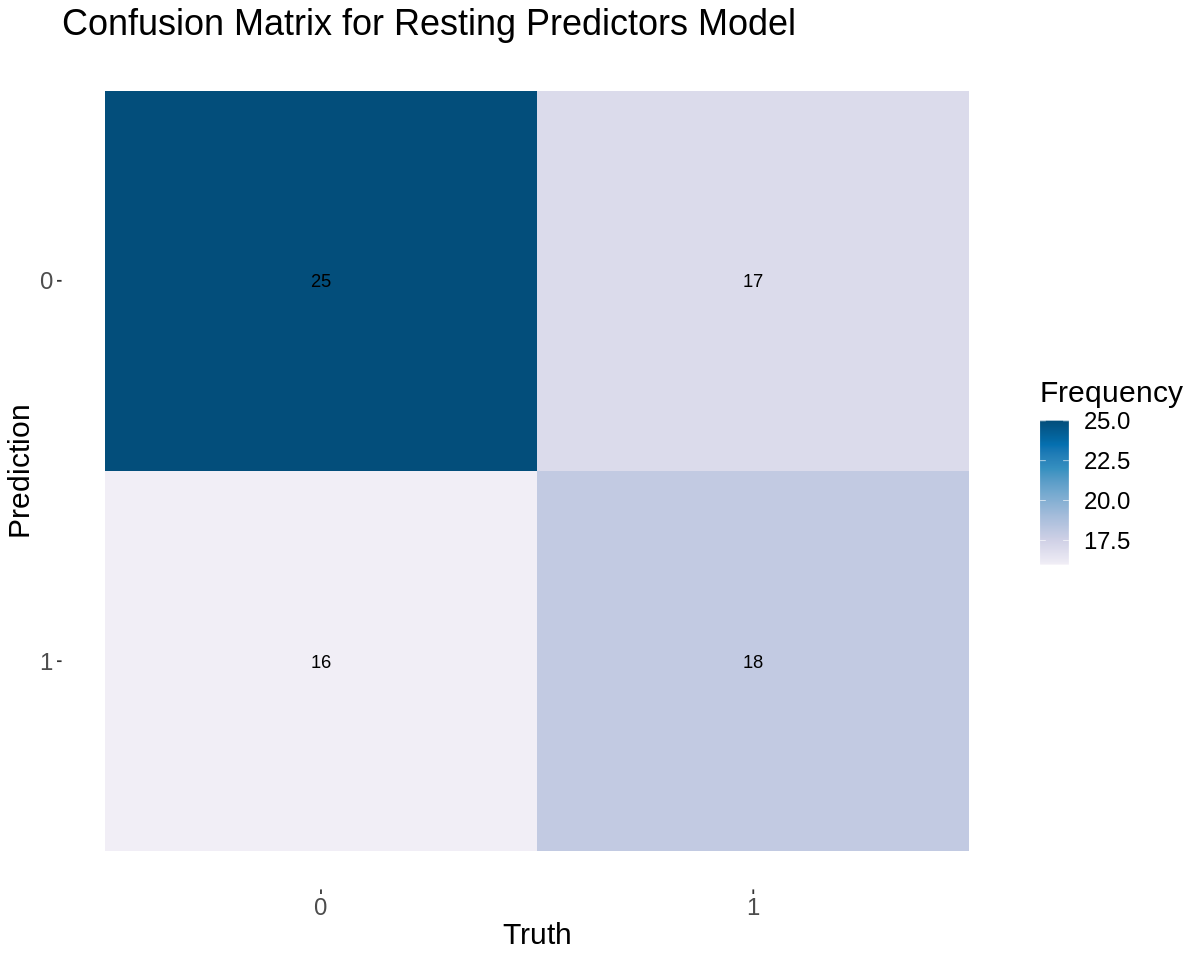

In [120]:
#visualizing the confusion matrix for the resting predictors model

autoplot(resting_conf_mat, type = "heatmap") +
    scale_fill_distiller(palette = "PuBu", direction = 1, name = "Frequency") +        
    labs(title = "Confusion Matrix for Resting Predictors Model") +
    theme(legend.position = "right", text = element_text(size = 18),
          plot.caption = element_text(size = 16, hjust = 0))

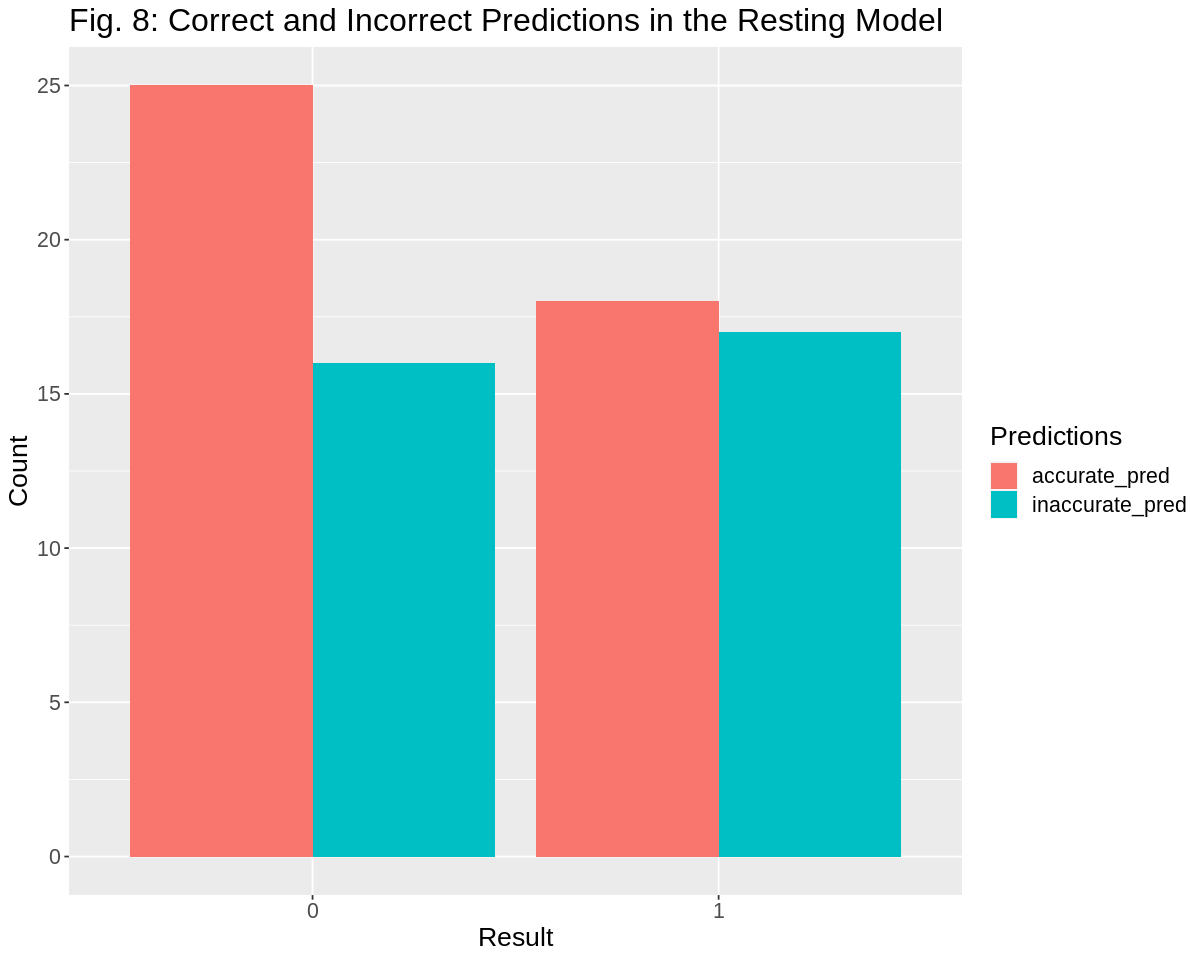

In [121]:
# Making the confusion matrix into a data frame.

resting_pred_accuracy <- resting_predictions |>
    group_by(result)|> 
    summarize(accurate_pred = sum(.pred_class == result), inaccurate_pred = sum(.pred_class != result))
    data_long <- reshape2::melt(resting_pred_accuracy, id.vars = "result")

# Visualizing the confusion matrix as a bar graph. 

resting_pred_accuracy_plot <- ggplot(data_long, aes(x = result, y = value, fill = variable)) +
    ggtitle("Fig. 8: Correct and Incorrect Predictions in the Resting Model") +
    geom_bar(stat="identity", position = "dodge") +
    labs(x = "Result", y = "Count", fill = "Predictions")+
    theme(text = element_text(size = 16))

resting_pred_accuracy_plot

This bar graph demonstrates the model's correct predictions compared its incorrect predictions, for each result. This emphasizes the model's innacuracy, as with each result, there are more incorrect than correct predictions. Thus, we must assess whether this model is sufficiently appropriate for clinicians.

Diagnosis of HD relies on "patient's history, their physical examination, and both laboratory and imaging data" (Olsen et al., 2020) and these should also be included in our modeling to make appropriate diagnoses (Olsen et al., 2020). With the predictors chosen in this model, we have restricted the data input to the model to only "their physical examination" (Olsen et al., 2020), and this being only a portion of it. This explains why our model's accuracy is low and performs worse than the majority classifier as it does not assess the variety of predictors required (Olsen et al., 2020). Due to the critical importance of HD diagnosis (Olsen et al., 2020), this model is likely not appropriate for clinicians. 

<b>EXERCISE PREDICTORS MODELLING</b>

The next model uses exercise predictors to predict HD diagnosis.

We need to determine whether the classes are balanced before modeling.

In [107]:
# Checking the amount of each of the results in our training set to determine if we have to balance the classes.
number_of_each_result_exercise <- exercise_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result_exercise

result,count
<fct>,<int>
0,123
1,104


<b>Table 5:</b> The number of each result in the training dataset indicates the classes are not balanced, there is more of the 0 result, thus we created a balanced dataset.

In [108]:
set.seed(9999)

# Creating a recipe to upsample the data so that we balance the classes. 
balanced_recipe_exercise <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                                step_upsample(result, over_ratio = 1, skip = FALSE) |>
                                prep()

# Baking this recipe with our training data so that the classes are balanced. 
balanced_exercise_train <- bake(balanced_recipe_exercise, exercise_train)

This recipe scales and centers the data so that all predictors have the same scale, and contribute equally to the model. It indicates  we are predicting for the result variable. 

In [109]:
# Creating a recipe for the classification using the resting data. 
set.seed(9999)

exercise_recipe <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

In [110]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

exercise_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

We perform cross-validation to find the best $K$ to use in this model. This determines the accuracy of each $K$ tried by testing the $K$ on portions of the training set called validation sets. 

In [111]:
set.seed(9999)

# Creating a cross validation. 

exercise_vfold <- vfold_cv(exercise_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 1))
                   
# Creating a workflow to determine the best K. 

exercise_model_workflow <- workflow() |>
                            add_recipe(exercise_recipe) |>
                            add_model(exercise_model_tune) |>
                            tune_grid(resamples = exercise_vfold, grid = k_to_try) |>
                            collect_metrics()

Using our cross-validation results we determine the best $K$, by plotting the $K$ tried with respect to their accuracy.

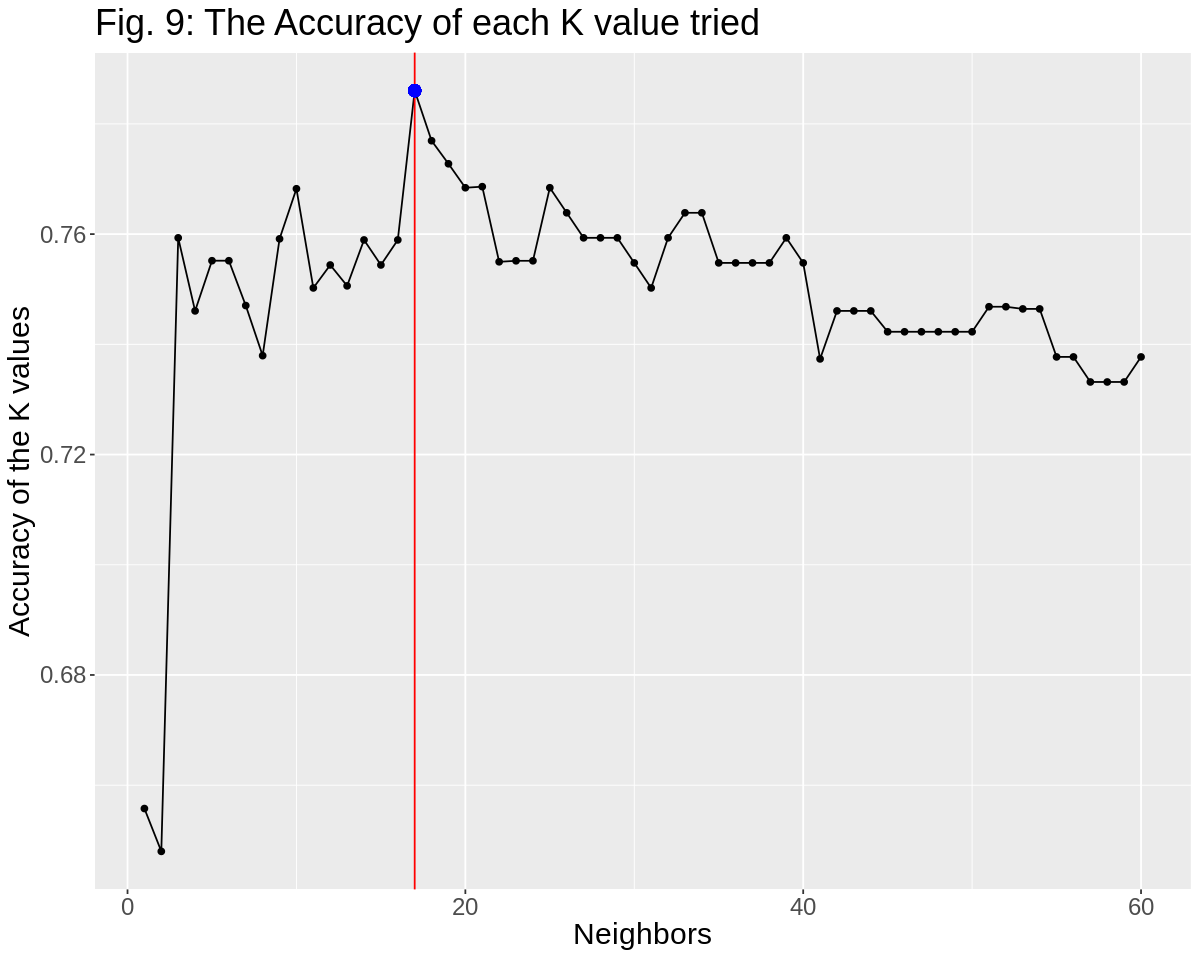

In [122]:
accuracy_of_k_exercise <- exercise_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

highest_accuracy <- accuracy_of_k_exercise |>
                filter(neighbors == 17) |> 
                select(mean) |>
                pull()

accuracy_plot_exercise <- accuracy_of_k_exercise |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 17, colour = "red") +
                    geom_point(aes(x = 17, y = highest_accuracy), size = 3, colour = "blue") +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("Fig. 9: The Accuracy of each K value tried") +
                    theme(text = element_text(size = 18))

accuracy_plot_exercise

From the above plot, we will choose $K$=25 as its accuracy is highest with adjacent values being highly accurate too.

Thus, we use this $K$ in a model fit to our training data, to predict results in the testing data.

In [123]:
set.seed(9999)

# Creating a new model which includes the K to generate the best fit. 

best_exercise_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_exercise_fit <- workflow() |>
                        add_recipe(exercise_recipe) |>
                        add_model(best_exercise_model) |>
                        fit(data = balanced_exercise_train)

# Fitting the model to our testing data to make the predictions. 

exercise_predictions <- best_exercise_fit |>
                        predict(exercise_test) |>
                        bind_cols(exercise_test)

Through analyzing the metrics and confusion matrix we can determine this model's success at predicting the testing data's classes.

In [124]:
set.seed(9999)

# Looking at the metrics and confusion matrix for this model to determine its accuracy.

exercise_metrics <- exercise_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
exercise_metrics

exercise_conf_mat <- exercise_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
exercise_conf_mat

[1] 0.6973684

          Truth
Prediction  0  1
         0 33 15
         1  8 20

<b>Table 6:</b> This exercise model has an accuracy of 0.45, indicating that approximately half of its predictions are correct. The confusion matrix shows that there are no data with a result of 4 in the testing data.

The majority classifier is the 0 result and it is 54%, thus our model performs worse than the majority classifier. However, its accuracy is closer to that of the majority classifier than the non-exercise model. 

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



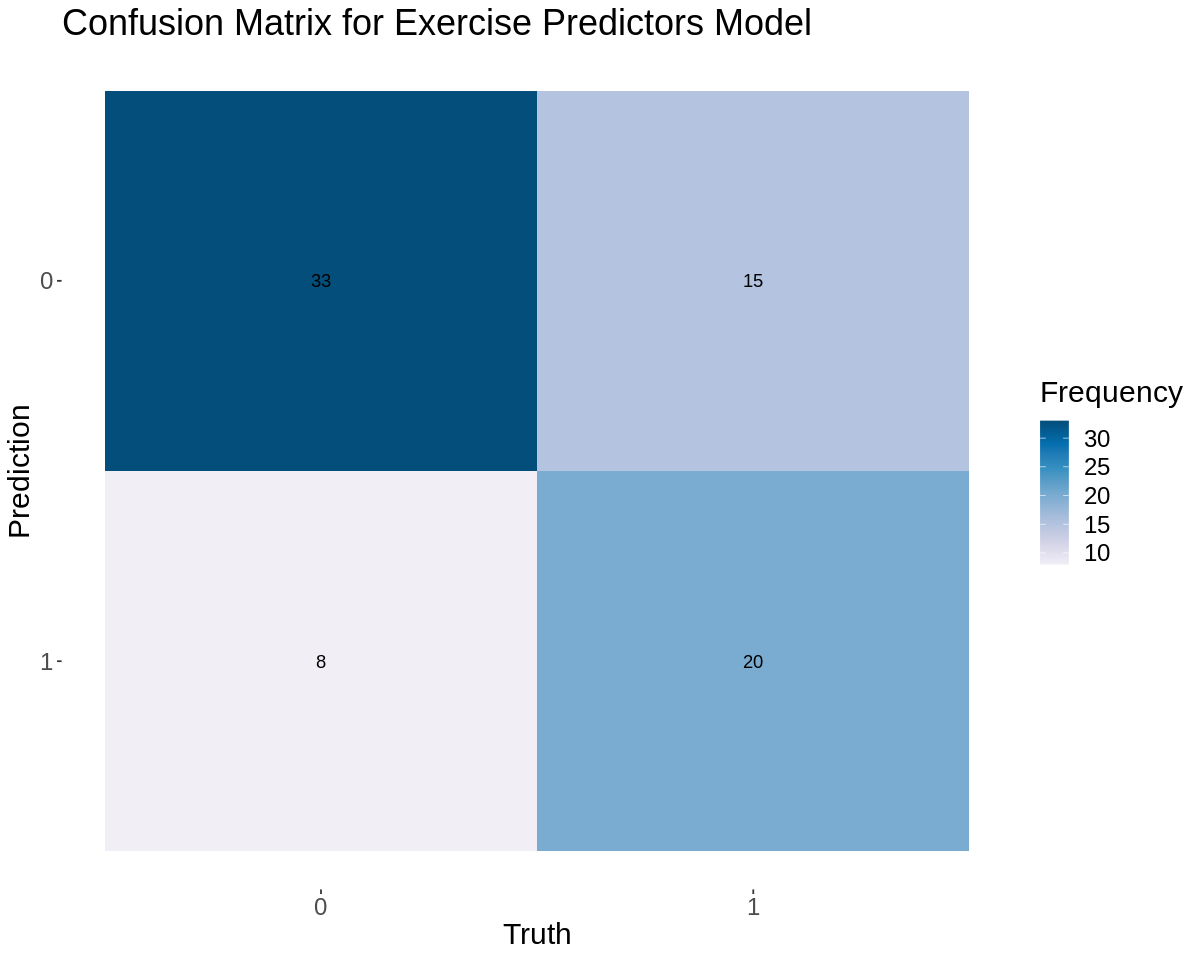

In [125]:
#visualizing the confusion matrix for the exercise predictors model

autoplot(exercise_conf_mat, type = "heatmap") +
    scale_fill_distiller(palette = "PuBu", direction = 1, name = "Frequency") +       
    labs(title = "Confusion Matrix for Exercise Predictors Model") +
    theme(legend.position = "right", text = element_text(size = 18),
          plot.caption = element_text(size = 16, hjust = 0))

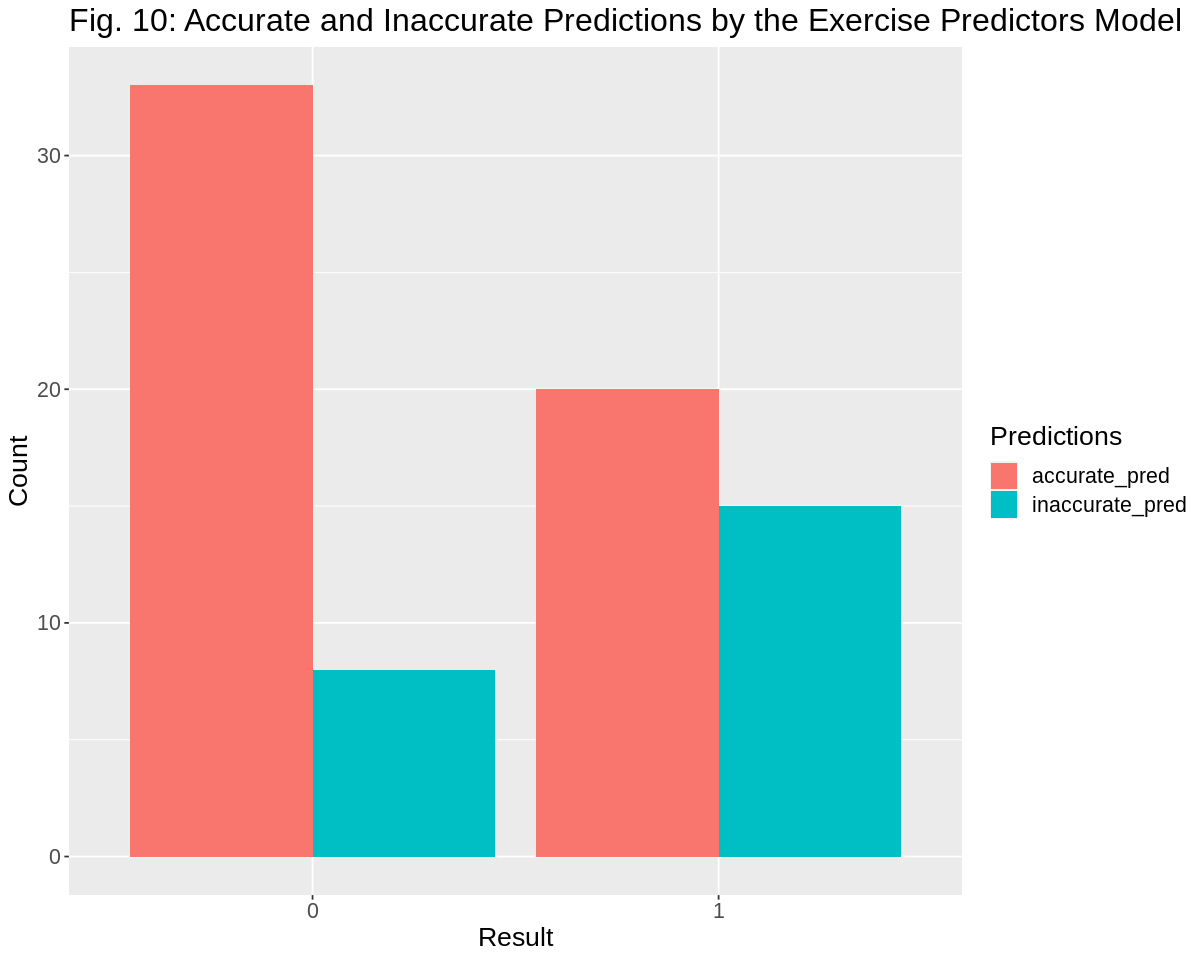

In [126]:
# Making a data frame from the confusion matrix data.
exercise_pred_accuracy <- exercise_predictions |>
    group_by(result)|> 
    summarize(accurate_pred = sum(.pred_class == result), inaccurate_pred = sum(.pred_class != result))
    data_long <- reshape2::melt(exercise_pred_accuracy, id.vars = "result")

# Visualizing the confustion matrix as a bar graph. 
exercise_pred_accuracy_plot <- ggplot(data_long, aes(x = result, y = value, fill = variable)) +
    ggtitle("Fig. 10: Accurate and Inaccurate Predictions by the Exercise Predictors Model") +
    geom_bar(stat="identity", position = "dodge") +
    labs(x = "Result", y = "Count", fill = "Predictions")+
    theme(text = element_text(size = 16))

exercise_pred_accuracy_plot

This plot identifies this model's accurate predictions compared to its inaccurate predictions. As with the previous model, this model makes more incorrect predictions than correct ones with results 1 and 3. However, this model makes more accurate than innacurate predictions when the result is 0, and makes an equal number of each for a result of 2. 

Again, to diagnosis HD clinically, we require analysis of predictors spanning a range of categories, that our model should also reflect (Olsen et al., 2020). However we have limited ourselves to only look at "their physical examination"(Olsen et al., 2020). This explains the low accuracy score for our model. However, exercise testing, otherwise known as stress tests, are important to diagnose HD as they force the individual's heart to pump blood hard, and thus be working at a rapid rate (Harvard Health Publishing, 2020). While the results of an exercise test alone are not completely accurate in diagnosing HD, clinically, they are coupled with risk factors such as age and cholesterol levels to perform the diagnosis (Harvard Health Publishing). This explains why our exercise model is more accurate than our non-exercise model. 



<b>References:</b>

Bösner, S., Becker, A., Hani, M.A., Keller, H., Sönnichsen, A.C., Haasenritter, J., Karatolios, K., Schaefer, J.R., Baum, E., and Donner-Banzhoff, N. (2010). Accuracy of Symptoms and Signs for Coronary Heart Disease Assessed in Primary Care. British Journal of General Practice, 60(575), 246-257. 10.3399/bjgp10X502137

Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Finkelhor, R.S., Newhouse, K.E., Vrobel, T.R., Miron, S.D., and Bahler, R.C. (1986). The ST Segment/Heart Rate Slope as a Predictor of Coronary Artery Disease: Comparison with Quantitative Thallium Imaging and Conventional ST Segment Criteria. American Heart Journal. 112(2). 296-304. https://doi.org/10.1016/0002-8703(86)90265-6

Harvard Health Publishing. (2021, September 21). Angina: Symptoms, diagnosis and treatments. Harvard Medical School. https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-andtreatments#:~:text=September%2021%2C%202021,by%20cholesterol%2Dclogged%20coronary%20arteries.

Harvard Health Publishing. (2020, April 15). Cardiac exercise stress testing: What it can and cannot tell you. Harvard Medical School. https://www.health.harvard.edu/heart-disease/cardiac-exercise-stress-testing-what-it-can-and-cannot-tell-you.

Lanza, G.A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G.A., and Crea, F. (2004). 
Diagnostic and Prognostic Value of ST Segment Depression Limited to the Recovery Phase of Exercise Stress Test. Heart. 90(12). 1417-1421. 10.1136/hrt.2003.031260


Olsen, C.R., Mentz, R.J, Anstrom, K.J., Page, D., and Patel, P.A. (2020). Clinical Applications of Machine Learning in the Diagnosis, Classification, and Prediction of Heart Failure. American Heart Journal, 229. 1-17. https://doi.org/10.1016/j.ahj.2020.07.009


Shin, J., Ham, D., Shin, S., Choi, S.K., Paik, H-Y., and Joung, H. (2019). Effects of 
Lifestyle-Related Factors on Ischemic Heart Disease According to Body Mass Index and Fasting Blood Glucose Levels in Korean Adults. PLoS ONE, 14(5), https://doi.org/10.1371/journal.pone.0216534

Wu, C-Y., Hu, H-Y., Chou, Y-J., Huang, N., Chou, Y-C., Li, C-P. (2015). High Blood Pressure 
and All-Cause and Cardiovascular Disease Mortalities in Community-Dwelling Older Adults. Medicine (Baltimore). 94(47). 10.1097/MD.0000000000002160
